In [ ]:
# faiss-gpu: a vector database from facebook
%pip -q install datasets transformers sentence_transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 16.8 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset

dataset = load_dataset('ArtifactAI/arxiv-physics-instruct-tune-30k')
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 30231
    })
})

In [ ]:
dataset['train'].to_pandas()

,question,answer
0,Which integral prime represents the least weight?,The least weight of an integral prime is 2. Th...
1,Earth moon distance to earth?,The average distance between the Earth and the...
2,What is the approximation of the extinction pr...,The approximation of extinction probability de...
3,What is the current moon-earth system?,"Currently, the moon is in its waning crescent ..."
4,What is the scalar radius of the pion?,The scalar radius of the pion is approximately...
...,...,...
30226,What are ultraluminous x rays?,Ultraluminous X-rays (ULXs) are a type of astr...
30227,A bohmian value is a standard value of?,Bohemian values can refer to a couple of diffe...
30228,Where is the spin down magnetic field located ...,The spin-down magnetic field of a pulsar is lo...
30229,How is scalar field theory solved?,Scalar field theory is a theory that describes...


In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct')
# tokenizer

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["question"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["answer"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]
# instruction_token_counts
# output_token_counts
# combined_token_counts

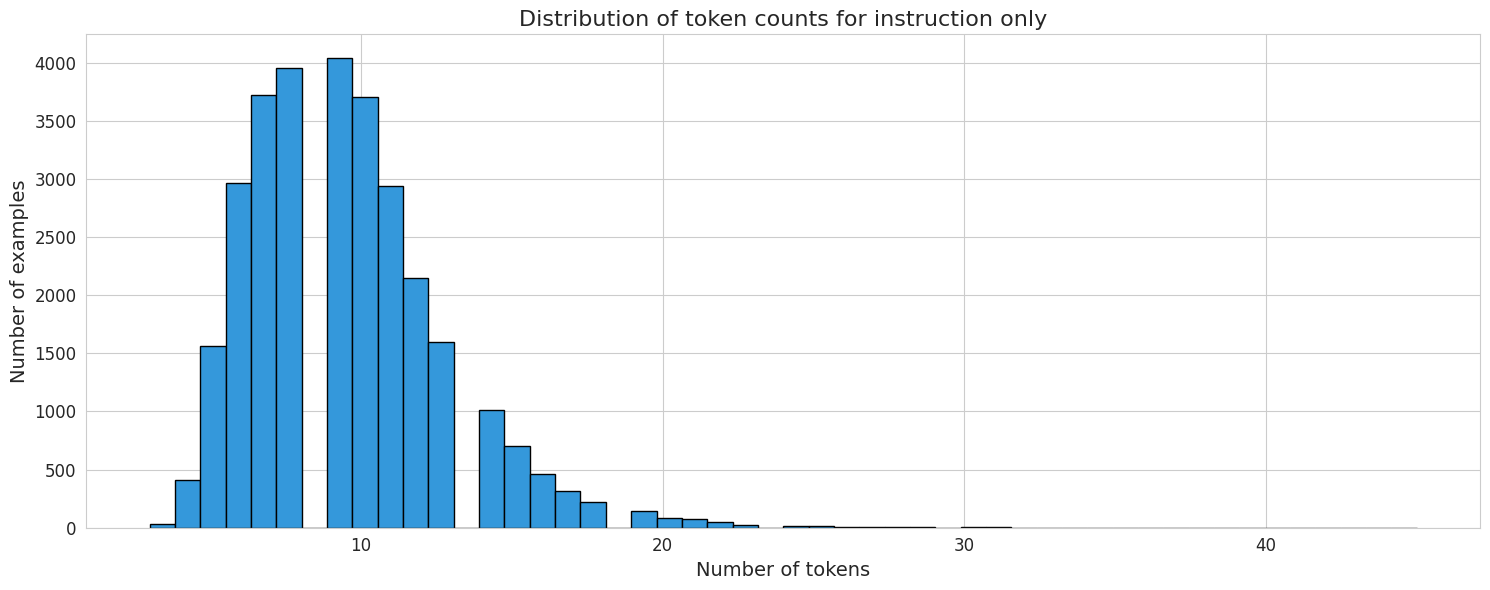

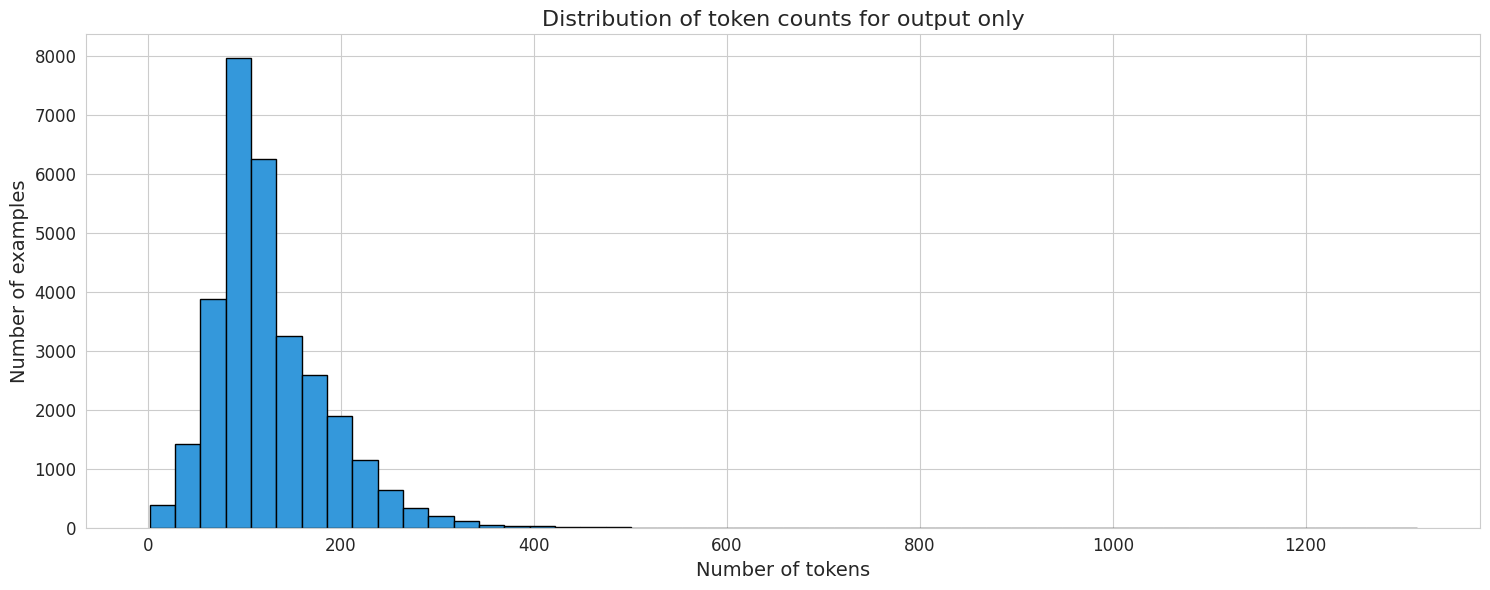

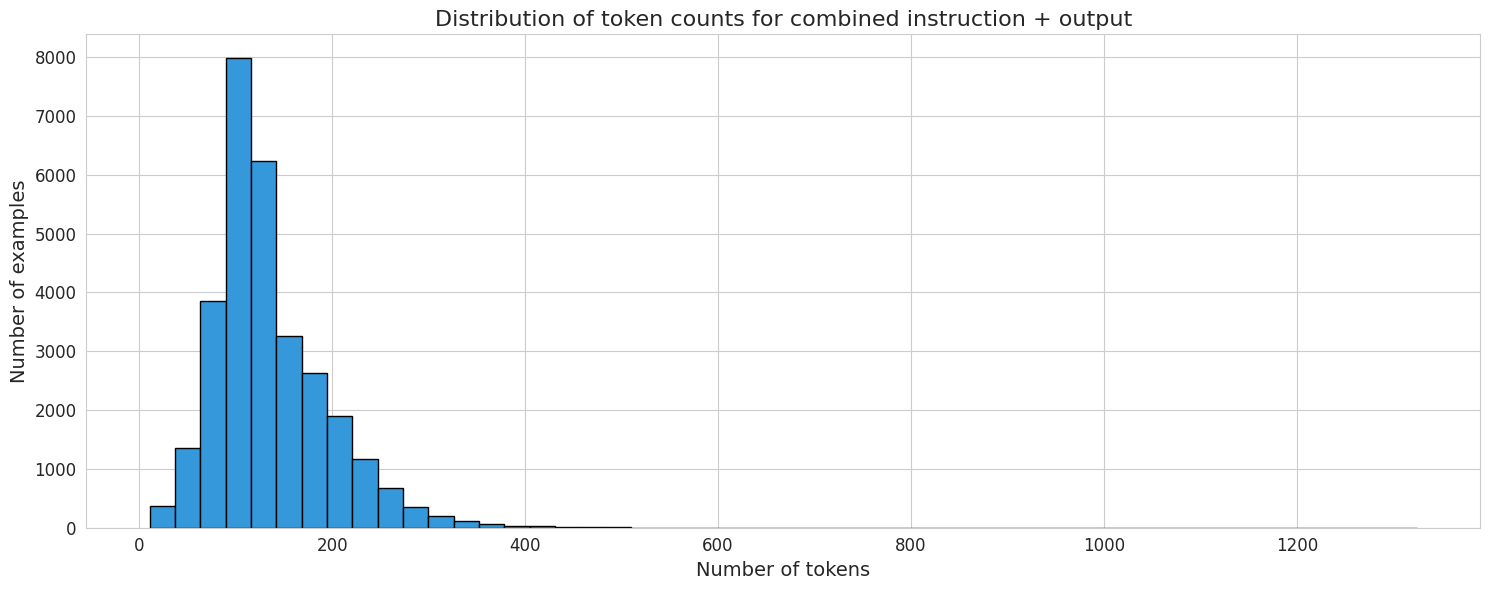

In [ ]:
# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [ ]:
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 512]
print(len(valid_indices))
print(len(dataset['train']) - len(valid_indices))

30211
20


In [ ]:
dataset['train'] = dataset['train'].select(valid_indices)

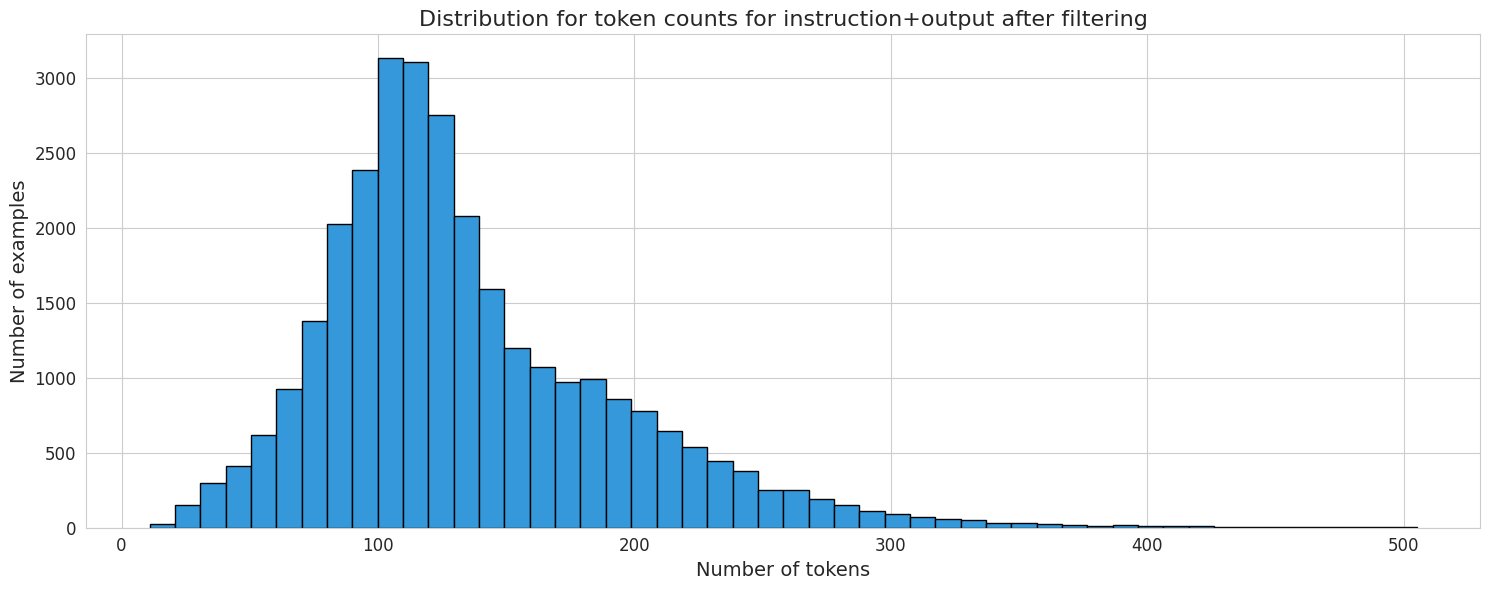

In [ ]:
token_counts = [combined_token_counts[i] for i in valid_indices]
plot_distribution(token_counts, "Distribution for token counts for instruction+output after filtering")

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["answer"] for example in dataset['train']]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Converting text to embeddings...


Batches:   0%|          | 0/945 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/30211 [00:00<?, ?it/s]

In [ ]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}") # original dataset
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}") # deduped dataset
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}") # the number of the samples that are removed

Number of samples in the original dataset: 30211
Number of samples in the deduped dataset: 26990
Number of samples that were removed: 3221


In [ ]:
# choosing the samples with the most tokens, as the dataset is still large and need to be pruned
# k: to know how many we want to have
def get_top_k_rows(dataset, token_counts, k):
    sorted_indices = sorted(range(len(token_counts)), key= lambda i: token_counts[i], reverse=True) # sorting by descending order
    top_k_indices = sorted_indices[:k] # keep just those top k
    top_k_data = {
        "instruction": [dataset['train'][i]["question"] for i in top_k_indices], # for loop to select all the samples in the sortde_indices to keep 1000 of them
        "output": [dataset['train'][i]["answer"] for i in top_k_indices],
    }
    return Dataset.from_dict(top_k_data)

instruction_token_counts = [len(tokenizer.tokenize(example["question"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["answer"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]
# instruction_token_counts
# output_token_counts
# combined_token_counts

k = 5000
top_k_dataset = get_top_k_rows(dataset, combined_token_counts, k)

dataset = DatasetDict({"train": top_k_dataset}) # save it as a dictionary to make sure we still have it as train split - nor much important

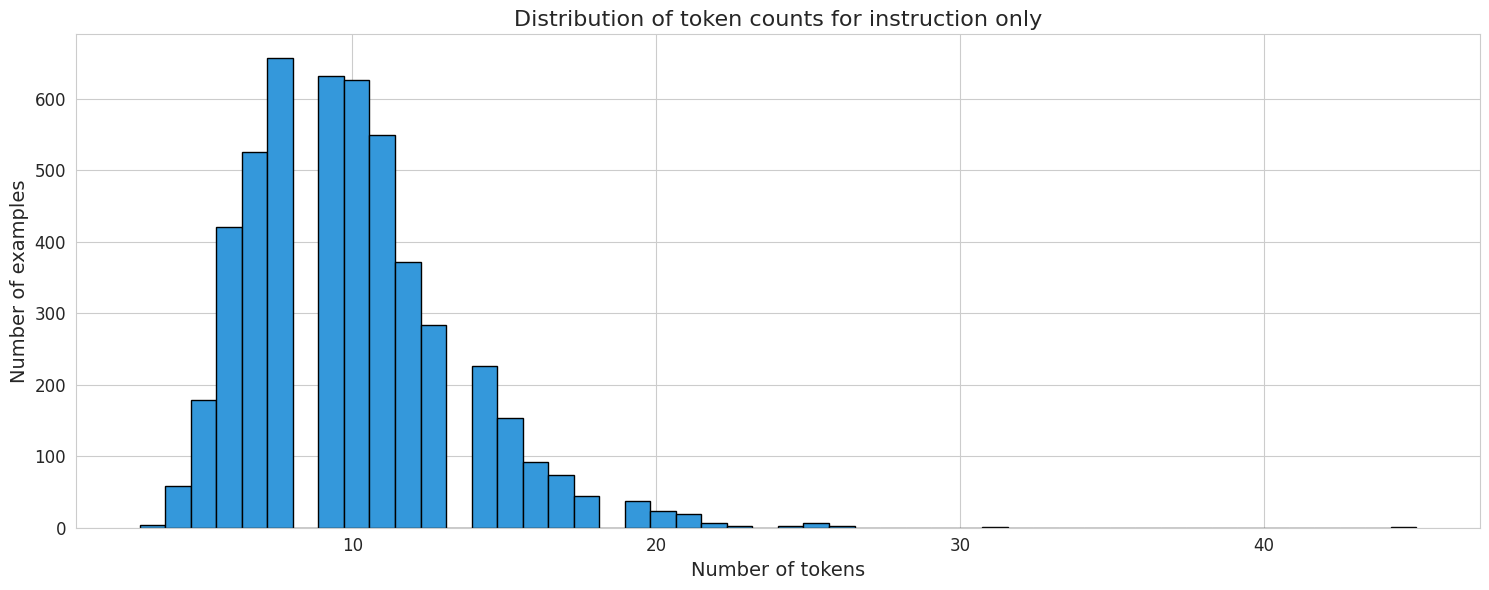

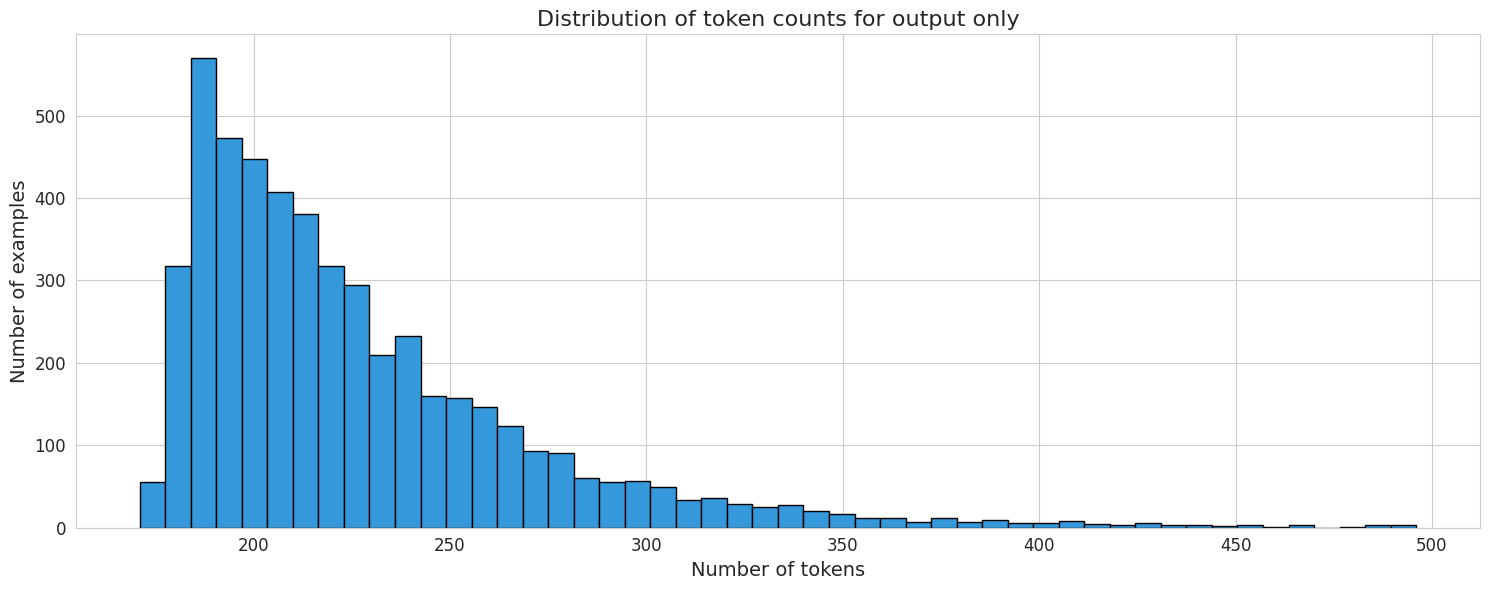

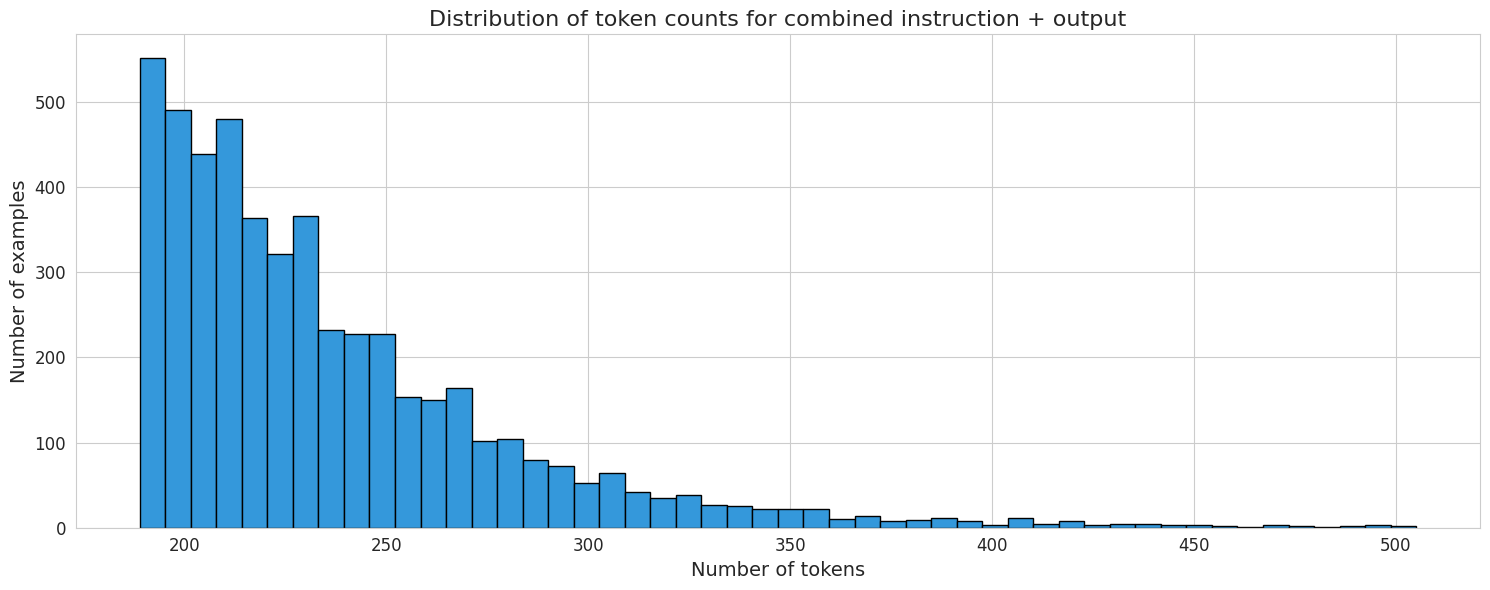

In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plot the new distribution of token counts after top k sampling
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [ ]:
# to check out the samples
dataset['train'].to_pandas()

,instruction,output
0,Laguerre polynomials inverse transform?,The inverse transform of Laguerre polynomials ...
1,Bessel moment proof of a recursive moment?,To prove the recursive moment formula for Bess...
2,Entwining class definition?,An entwining class is a mathematical concept t...
3,Integral of motion of virasoro algebra?,The Virasoro algebra is a mathematically impor...
4,Bloch vector for qudits?,A Bloch vector is a geometric representation o...
...,...,...
4995,Where are the branches of d0- pi+?,The decay of D0 → π+ π- involves the productio...
4996,Musiela's partial differential equation?,Musielak's partial differential equation is a ...
4997,What is the lempert function?,The Lempert function is a mathematical functio...
4998,What is nonperturbative screening?,Nonperturbative screening is a phenomenon in q...


In [ ]:
def chat_template(example):
    example["instruction"] = f"### Instruction: \n{example['instruction']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
dataset['train'].to_pandas()

,instruction,output
0,### Instruction: \nLaguerre polynomials invers...,The inverse transform of Laguerre polynomials ...
1,### Instruction: \nBessel moment proof of a re...,To prove the recursive moment formula for Bess...
2,### Instruction: \nEntwining class definition?...,An entwining class is a mathematical concept t...
3,### Instruction: \nIntegral of motion of viras...,The Virasoro algebra is a mathematically impor...
4,### Instruction: \nBloch vector for qudits?\n\...,A Bloch vector is a geometric representation o...
...,...,...
4995,### Instruction: \nWhere are the branches of d...,The decay of D0 → π+ π- involves the productio...
4996,### Instruction: \nMusiela's partial different...,Musielak's partial differential equation is a ...
4997,### Instruction: \nWhat is the lempert functio...,The Lempert function is a mathematical functio...
4998,### Instruction: \nWhat is nonperturbative scr...,Nonperturbative screening is a phenomenon in q...


In [ ]:
# just push the dataset to the huggingface hub
dataset.push_to_hub("mini-physics-5k", token=hf_token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/nmdr/mini-physics-5k/commit/f5e9873ed37d46fd5617edf8e84cdf37c301f017', commit_message='Upload dataset', commit_description='', oid='f5e9873ed37d46fd5617edf8e84cdf37c301f017', pr_url=None, pr_revision=None, pr_num=None)